In [1]:
import numpy as np
from matplotlib import pyplot as plt
import simple_GP_temperature.helper_sklearn as helper
from simple_GP_temperature.bell_curve import Bellcurve
from simple_GP_temperature.non_convex_function import NonConvexFunction
from simple_GP_temperature.random_initial_2d import RandomInit2D
from simple_GP_temperature.BO_GP_temperature import BOTemperatureGP
from simple_GP_temperature.fullfactor_initial import FullFactorInitial2D
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import entropy
from scipy.stats import gaussian_kde
from tqdm import tqdm

In [2]:
objective = NonConvexFunction()

In [3]:
def find_stable_point(data_dict, start_index, threshold):
     # Convert the dictionary to a list of items, sorted by the keys
     data_list = sorted(list(data_dict.items()))
     # Start from the given index
     for i in range(start_index, len(data_list)-1):
         # Calculate the difference between the current and next value
         if i+3 <= len(data_list)-1:
             difference = abs(((data_list[i][1]-data_list[i+1][1])+(data_list[i+1][1] - data_list[i+2][1])+(data_list[i+2][1]-data_list[i+3][1]))/3)
         else:
             difference = threshold+1
         # If the difference is below the threshold, return the current index
         if difference < threshold:
             return i

     # If no stable point was found, return None
     return None

In [8]:
def imporvement_curve(data_dict, start_index):
    #convert the dictionary to a list of items, sorted by the keys 
    data_list = sorted(list(data_dict.items()))
    result_curve = []
    result_curve.append(data_list[start_index][1])
    for i in range(start_index,len(data_list)-1):
        if data_list[i][1]>result_curve[-1]:
            result_curve.append(data_list[i][1])
        else: result_curve.append(result_curve[-1])
    return result_curve

In [5]:
def Welch_t_test(impro_iter_num_lst_1, impro_iter_num_lst_2):
    p_value_curve = []
    for i in range(20):
        sample_1 = impro_iter_num_lst_1[i][:]
        sample_2 = impro_iter_num_lst_2[i][:]
        t_statistic,p_value = ttest_ind(sample_1,sample_2, equal_var = False)
        p_value_curve.append(p_value)
    return p_value_curve

    
    

In [6]:
def sample_entropy(initial_sample_lst):
    initial_sample = np.array(initial_sample_lst)
    kde = gaussian_kde(initial_sample.T)
    x_grid, y_grid = np.meshgrid(np.linspace(initial_sample[:, 0].min(), initial_sample[:, 0].max(), 100),
                             np.linspace(initial_sample[:, 1].min(), initial_sample[:, 1].max(), 100))
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    pdf_values = kde(positions)
    sample_entropy = entropy(pdf_values, base=2)
    print("Entropy of the initial sample:", sample_entropy)
    return sample_entropy


# random initial around local optimal

In [7]:
from simple_GP_temperature.local_optima_initial_non_convex_2d import LocalOptimaInit2DNonConvex
local_optima_init=LocalOptimaInit2DNonConvex()
bayes_opt_local_opt = BOTemperatureGP(evaluation_component=objective, initial_method=local_optima_init, 
                                      lower_bound=[-10,-10], upper_bound=[20,20], total_iter=100)
local_opt_mappings_lst=[]
for i in tqdm(range(50)):
    local_opt_mappings_lst.append(bayes_opt_local_opt.optimise())

100%|███████████████████████████████████████████| 50/50 [19:03<00:00, 22.86s/it]


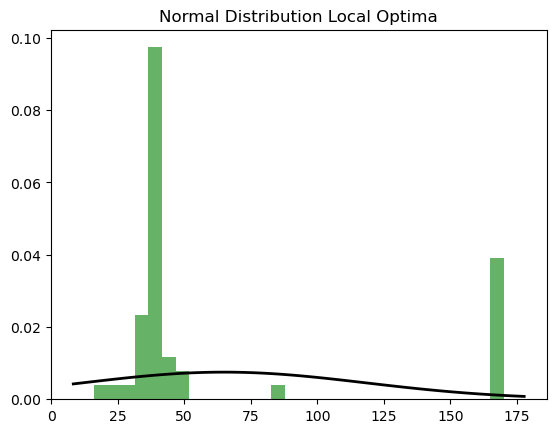

In [9]:
threshold = 0.1
converge_iter_num_lst_random = []
for local_opt_mappings in local_opt_mappings_lst:
    converge_iter_num_lst_random.append(find_stable_point(local_opt_mappings, 8, threshold))

none_replacement = max([x for x in converge_iter_num_lst_random if x is not None]) * 2  # you can adjust this as needed
replaced_list = [x if x is not None else none_replacement for x in converge_iter_num_lst_random]
numbers = replaced_list
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

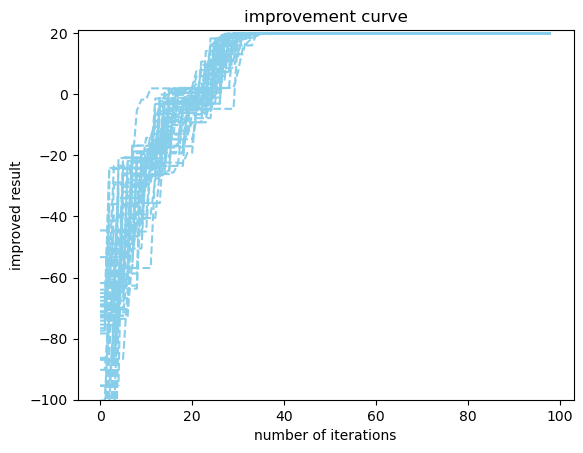

In [13]:
impro_iter_num_lst_random = []
for local_opt_mappings in local_opt_mappings_lst:
    impro_iter_num_lst_random.append(imporvement_curve(local_opt_mappings, start_index = 9))

for i, y_values in enumerate(impro_iter_num_lst_random):
    plt.plot(range(len(impro_iter_num_lst_random[i])), y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.ylim(-100,21)
plt.show()

# Full Factorial design around local optimal

In [17]:
initial_sample_lst = [[13,13],
                      [10,13],
                      [7,13],
                      [13,10],
                      [10,10],
                      [7,10],
                      [13,7],
                      [10,7],
                      [7,7]]
initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)
bayes_opt_fullfactor = BOTemperatureGP(evaluation_component=objective, 
                                       initial_method=initial_method, 
                                       initial_sample_size= 9, lower_bound=[-20,-20], upper_bound=[20,20], 
                                       total_iter=100)

In [18]:
sample_entropy(initial_sample_lst)

Entropy of the initial sample: 13.284136275506961


13.284136275506961

In [19]:
fullfactor_mappings_lst=[]
for i in tqdm(range(50)):
    fullfactor_mappings_lst.append(bayes_opt_fullfactor.optimise())

100%|███████████████████████████████████████████| 50/50 [23:46<00:00, 28.54s/it]


In [20]:
threshold = 0.1
converge_iter_num_lst_fullfactor = []
for fullfactor_mappings in fullfactor_mappings_lst:
    converge_iter_num_lst_fullfactor.append(find_stable_point(fullfactor_mappings, start_index = 9, threshold = 0.1))

none_replacement = max([x for x in converge_iter_num_lst_fullfactor if x is not None]) * 2 
replaced_list = [x if x is not None else none_replacement for x in converge_iter_num_lst_fullfactor]

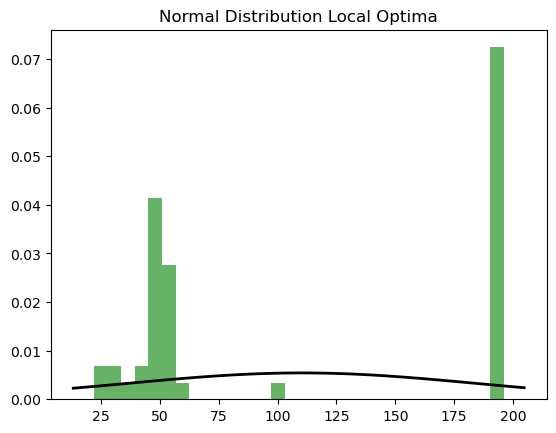

In [21]:
numbers_1 = replaced_list
plt.hist(numbers_1, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers_1)), 2) / (2 * np.std(numbers_1) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers_1))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

In [22]:
impro_iter_num_lst_1 = []
for fullfactor_mappings in fullfactor_mappings_lst:
    impro_iter_num_lst_1.append(imporvement_curve(fullfactor_mappings, start_index = 9))


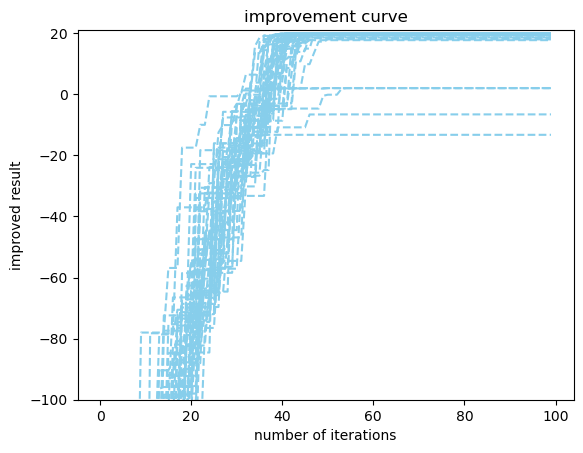

In [32]:
for i, y_values in enumerate(impro_iter_num_lst_1):
    plt.plot((range(len(impro_iter_num_lst_1[i]))), y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.ylim(-100,21)
plt.show()


In [33]:
p_value_curve_1 = Welch_t_test(impro_iter_num_lst_random, impro_iter_num_lst_1)

# D-optimal design around local optimal with 8 samples 

In [34]:
initial_sample_lst = [[7,7],
                      [7,10],
                      [7,13],
                      [9.88,7],
                      [9.88,13],
                      [10.72,10],
                      [13,7],
                      [13,13]]
initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)
bayes_opt_doptimal_7 = BOTemperatureGP(evaluation_component=objective, 
                                       initial_method=initial_method, 
                                       initial_sample_size= 8, lower_bound=[-10,-10], upper_bound=[10,10], total_iter=100)

In [35]:
sample_entropy(initial_sample_lst)

Entropy of the initial sample: 13.278305441509602


13.278305441509602

In [37]:
doptimal_mappings_lst_1=[]
for i in tqdm(range(50)):
    doptimal_mappings_lst_1.append(bayes_opt_doptimal_7.optimise())

100%|███████████████████████████████████████████| 50/50 [03:19<00:00,  4.00s/it]


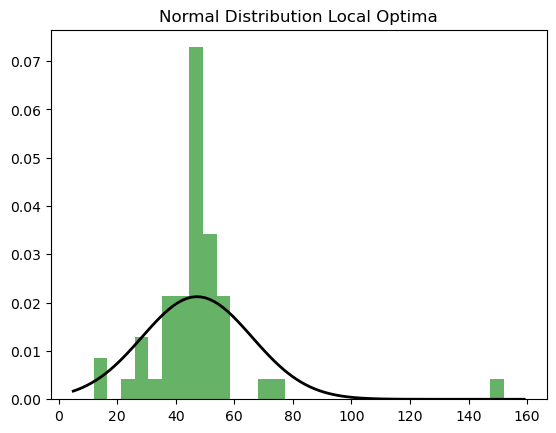

In [38]:
threshold = 0.1
converge_iter_num_lst_doptimal_7 = []
for doptimal_mappings in doptimal_mappings_lst_1:
    converge_iter_num_lst_doptimal_7.append(find_stable_point(doptimal_mappings, start_index = 7, threshold = 0.1))

none_replacement = max([x for x in converge_iter_num_lst_doptimal_7 if x is not None]) * 2  # you can adjust this as needed
replaced_list_7 = [x if x is not None else none_replacement for x in converge_iter_num_lst_doptimal_7]
numbers = replaced_list_7
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

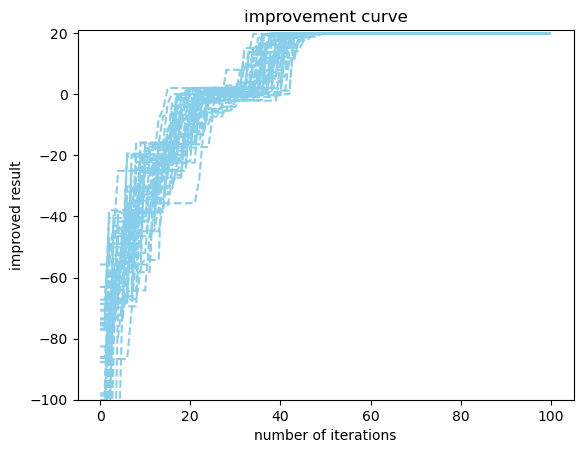

In [39]:
impro_iter_num_lst_2 = []
for doptimal_mappings in doptimal_mappings_lst_1:
    impro_iter_num_lst_2.append(imporvement_curve(doptimal_mappings, start_index = 7))

for i, y_values in enumerate(impro_iter_num_lst_2):
    x_value = range(len(y_values))
    plt.plot(x_value, y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.ylim(-100,21)
plt.show()

In [40]:
p_value_curve_2 = Welch_t_test(impro_iter_num_lst_random, impro_iter_num_lst_2)

# I-optimal design around local optimal with 8 samples 

In [63]:
initial_sample_lst = [[7,7],
                      [7,10.36],
                      [7,13],
                      [10,9.04],
                      [10,9.76],
                      [10.6,13],
                      [13,7],
                      [13,11.56]]
initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)
bayes_opt_ioptimal_7 = BOTemperatureGP(evaluation_component=objective, 
                                       initial_method=initial_method, 
                                       initial_sample_size= 8, lower_bound=[-20,-20], upper_bound=[20,20], total_iter=100)

In [64]:
sample_entropy(initial_sample_lst)

Entropy of the initial sample: 13.265404744572171


13.265404744572171

In [79]:
ioptimal_mappings_lst_1=[]
for i in tqdm(range(50)):
    ioptimal_mappings_lst_1.append(bayes_opt_ioptimal_7.optimise())

100%|███████████████████████████████████████████| 50/50 [03:19<00:00,  4.00s/it]


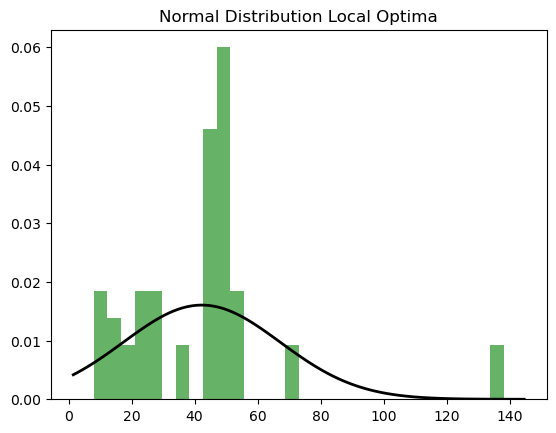

In [81]:
threshold = 0.1
converge_iter_num_lst_ioptimal_7 = []
for ioptimal_mappings in ioptimal_mappings_lst_1:
    converge_iter_num_lst_ioptimal_7.append(find_stable_point(ioptimal_mappings, start_index = 7, threshold = 0.1))
    
none_replacement = max([x for x in converge_iter_num_lst_ioptimal_7 if x is not None]) * 2  # you can adjust this as needed
replaced_list_i_7 = [x if x is not None else none_replacement for x in converge_iter_num_lst_ioptimal_7]
numbers = replaced_list_i_7
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

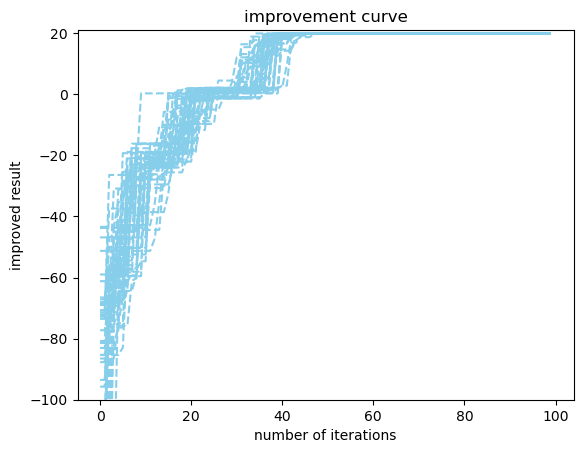

In [83]:
impro_iter_num_lst_i = []
for ioptimal_mappings in ioptimal_mappings_lst_1:
    impro_iter_num_lst_i.append(imporvement_curve(ioptimal_mappings, start_index = 8))

for i, y_values in enumerate(impro_iter_num_lst_i):
    x_value = range(len(y_values))
    plt.plot(x_value, y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.ylim(-100,21)
plt.show()

In [84]:
p_value_curve_i_1 = Welch_t_test(impro_iter_num_lst_random, impro_iter_num_lst_i)

# D-optimal design around local optimal with 12 samples

In [48]:
initial_sample_lst = [
    [7,7],
    [7,10],
    [7,13],
    [7.12,7],
    [7.12,13],
    [10,7],
    [10,10],
    [10.36,13],
    [12.88,7],
    [13,7],
    [13,10.36],
    [13,13]]

initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)
bayes_opt_doptimal_11 = BOTemperatureGP(evaluation_component=objective, initial_method=initial_method, initial_sample_size= 12, lower_bound=[-10,-10], upper_bound=[10,10], total_iter=100)
doptimal_mappings_lst_2=[]
for i in tqdm(range(50)):
    doptimal_mappings_lst_2.append(bayes_opt_doptimal_11.optimise())


100%|███████████████████████████████████████████| 50/50 [03:17<00:00,  3.95s/it]


In [49]:
sample_entropy(initial_sample_lst)

Entropy of the initial sample: 13.284063171664561


13.284063171664561

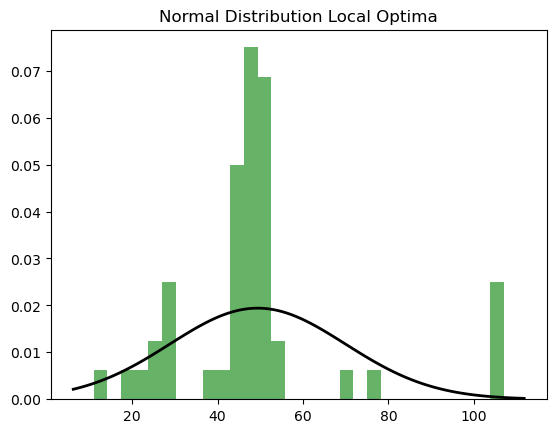

In [50]:
threshold = 0.1
converge_iter_num_lst_3 = []
for doptimal_mappings in doptimal_mappings_lst_2:
    converge_iter_num_lst_3.append(find_stable_point(doptimal_mappings, start_index = 11, threshold = 0.1))

none_replacement = max([x for x in converge_iter_num_lst_3 if x is not None]) * 2  # you can adjust this as needed
replaced_list = [x if x is not None else none_replacement for x in converge_iter_num_lst_3]
numbers = replaced_list
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

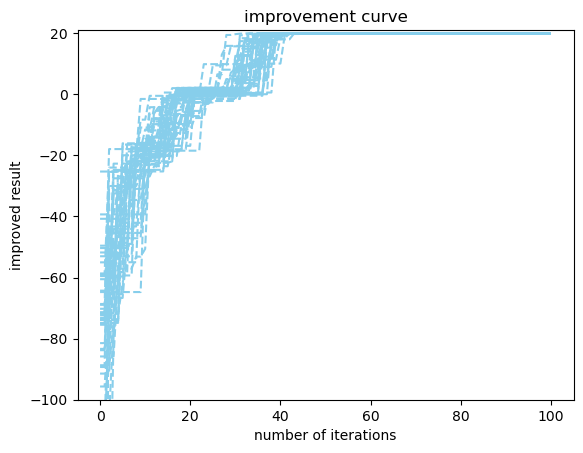

In [51]:
impro_iter_num_lst_3 = []
for doptimal_mappings in doptimal_mappings_lst_2:
    impro_iter_num_lst_3.append(imporvement_curve(doptimal_mappings, start_index = 11))

for i, y_values in enumerate(impro_iter_num_lst_3):
    x_value = range(len(y_values))
    plt.plot(x_value, y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')
    

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.ylim(-100,21)
plt.show()

In [52]:
p_value_curve_3 = Welch_t_test(impro_iter_num_lst_random, impro_iter_num_lst_3)

# I-optimal design around local optimal with 12 samples

In [101]:
initial_sample_lst = [
    [7,7],
    [7,10],
    [7,13],
    [9.76,10],
    [9.88,9.64],
    [10,9.52],
    [10,10],
    [10,7],
    [10.12,13],
    [13,7],
    [13,10],
    [13,13]]

initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)
bayes_opt_ioptimal_12 = BOTemperatureGP(evaluation_component=objective, initial_method=initial_method, initial_sample_size= 12, lower_bound=[-15,-15], upper_bound=[15,15], total_iter=100)
ioptimal_mappings_lst_2=[]
for i in tqdm(range(50)):
    ioptimal_mappings_lst_2.append(bayes_opt_ioptimal_12.optimise())


100%|███████████████████████████████████████████| 50/50 [14:36<00:00, 17.54s/it]


In [94]:
sample_entropy(initial_sample_lst)

Entropy of the initial sample: 13.211910647485727


13.211910647485727

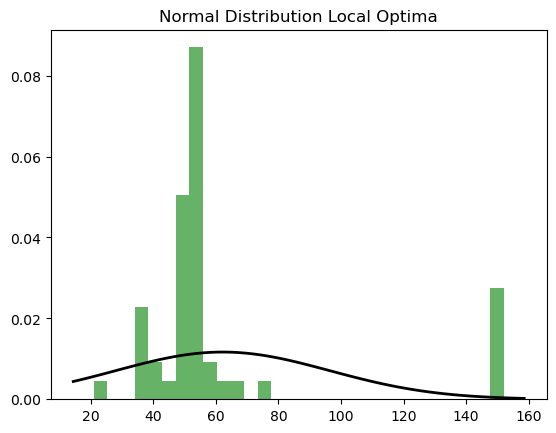

In [103]:
threshold = 0.1
converge_iter_num_lst_i_2 = []
for ioptimal_mappings in ioptimal_mappings_lst_2:
    converge_iter_num_lst_i_2.append(find_stable_point(ioptimal_mappings, start_index = 12, threshold = 0.1))

none_replacement = max([x for x in converge_iter_num_lst_i_2 if x is not None]) * 2  # you can adjust this as needed
replaced_list = [x if x is not None else none_replacement for x in converge_iter_num_lst_i_2]
numbers = replaced_list
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

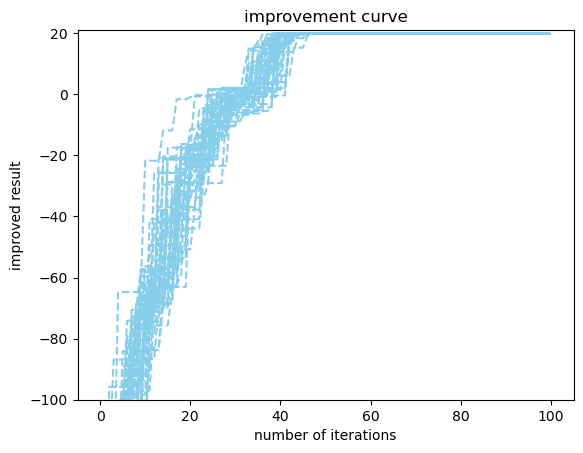

In [105]:
impro_iter_num_lst_i_2 = []
for ioptimal_mappings in ioptimal_mappings_lst_2:
    impro_iter_num_lst_i_2.append(imporvement_curve(ioptimal_mappings, start_index = 11))

for i, y_values in enumerate(impro_iter_num_lst_i_2):
    x_value = range(len(y_values))
    plt.plot(x_value, y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')
    

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.ylim(-100,21)
plt.show()

In [106]:
p_value_curve_i_2 = Welch_t_test(impro_iter_num_lst_random, impro_iter_num_lst_i_2)

# D-optimal design around local optimal with 14 samples

In [68]:
initial_sample_lst = [
    [7,7],
    [7,10],
    [7,12.88],
    [7,13],
    [7.12,7],
    [10,7],
    [10,9.88],
    [10,10],
    [10,13],
    [12.88,7],
    [13,7],
    [13,10],
    [13,12.88],
    [13,13]]

initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)
bayes_opt_doptimal_13 = BOTemperatureGP(evaluation_component=objective, 
                                        initial_method=initial_method, initial_sample_size= 13, 
                                        lower_bound=[-10,-10], upper_bound=[10,10], total_iter=50)
doptimal_mappings_lst_4=[]
for i in tqdm(range(50)):
    doptimal_mappings_lst_4.append(bayes_opt_doptimal_13.optimise())

100%|███████████████████████████████████████████| 50/50 [03:23<00:00,  4.08s/it]


In [69]:
sample_entropy(initial_sample_lst)

Entropy of the initial sample: 13.244611100023919


13.244611100023919

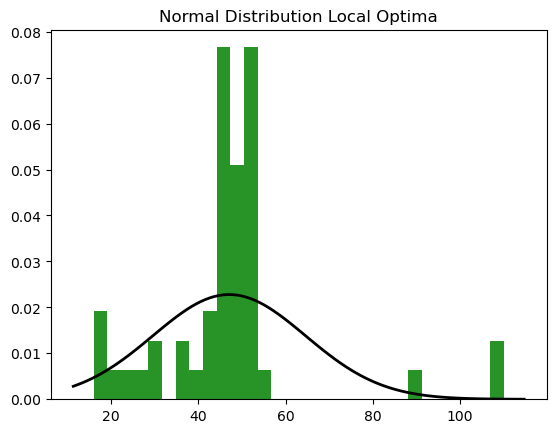

In [70]:
threshold = 0.1
converge_iter_num_lst_5 = []
for doptimal_mappings in doptimal_mappings_lst_4:
    converge_iter_num_lst_5.append(find_stable_point(doptimal_mappings, start_index = 13, threshold = 0.1))
numbers = converge_iter_num_lst_5
none_replacement = max([x for x in converge_iter_num_lst_5 if x is not None]) * 2  # you can adjust this as needed
replaced_list = [x if x is not None else none_replacement for x in converge_iter_num_lst_5]
numbers = replaced_list
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

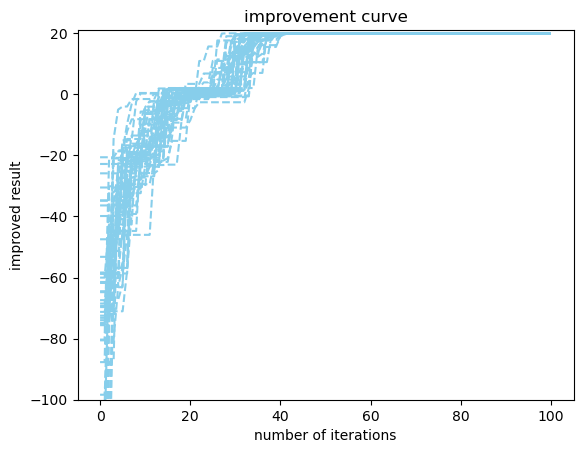

In [71]:
impro_iter_num_lst_5 = []
for doptimal_mappings in doptimal_mappings_lst_4:
    impro_iter_num_lst_5.append(imporvement_curve(doptimal_mappings, start_index = 13))

for i, y_values in enumerate(impro_iter_num_lst_5):
    x_value = range(len(y_values))
    plt.plot(x_value, y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.ylim(-100,21)
plt.show()

In [72]:
p_value_curve_4 = Welch_t_test(impro_iter_num_lst_random, impro_iter_num_lst_5)

# D-optimal design around local optimal with 14 samples

In [68]:
initial_sample_lst = [
    [7,7],
    [7,10],
    [7,12.88],
    [7,13],
    [7.12,7],
    [10,7],
    [10,9.88],
    [10,10],
    [10,13],
    [12.88,7],
    [13,7],
    [13,10],
    [13,12.88],
    [13,13]]

initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)
bayes_opt_doptimal_13 = BOTemperatureGP(evaluation_component=objective, 
                                        initial_method=initial_method, initial_sample_size= 13, 
                                        lower_bound=[-10,-10], upper_bound=[10,10], total_iter=50)
doptimal_mappings_lst_4=[]
for i in tqdm(range(50)):
    doptimal_mappings_lst_4.append(bayes_opt_doptimal_13.optimise())

100%|███████████████████████████████████████████| 50/50 [03:23<00:00,  4.08s/it]


In [69]:
sample_entropy(initial_sample_lst)

Entropy of the initial sample: 13.244611100023919


13.244611100023919

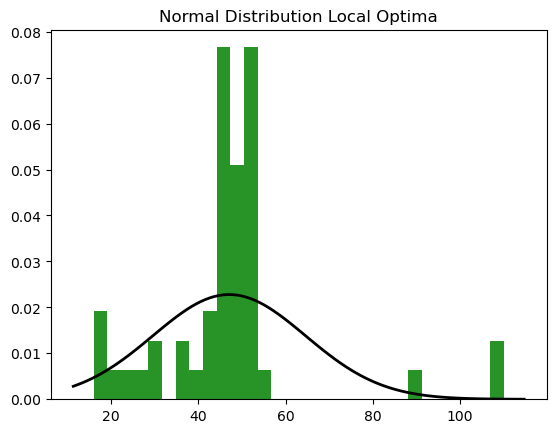

In [70]:
threshold = 0.1
converge_iter_num_lst_5 = []
for doptimal_mappings in doptimal_mappings_lst_4:
    converge_iter_num_lst_5.append(find_stable_point(doptimal_mappings, start_index = 13, threshold = 0.1))
numbers = converge_iter_num_lst_5
none_replacement = max([x for x in converge_iter_num_lst_5 if x is not None]) * 2  # you can adjust this as needed
replaced_list = [x if x is not None else none_replacement for x in converge_iter_num_lst_5]
numbers = replaced_list
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()

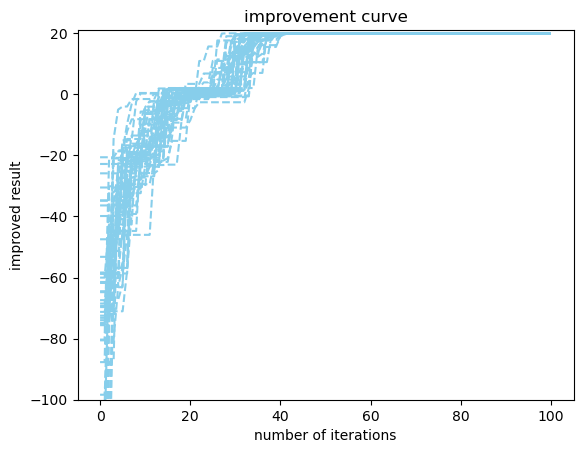

In [71]:
impro_iter_num_lst_5 = []
for doptimal_mappings in doptimal_mappings_lst_4:
    impro_iter_num_lst_5.append(imporvement_curve(doptimal_mappings, start_index = 13))

for i, y_values in enumerate(impro_iter_num_lst_5):
    x_value = range(len(y_values))
    plt.plot(x_value, y_values, linestyle='--', label=f'Data {i+1}',color = 'skyblue')

plt.title('improvement curve')
plt.xlabel('number of iterations')
plt.ylabel('improved result')
plt.ylim(-100,21)
plt.show()

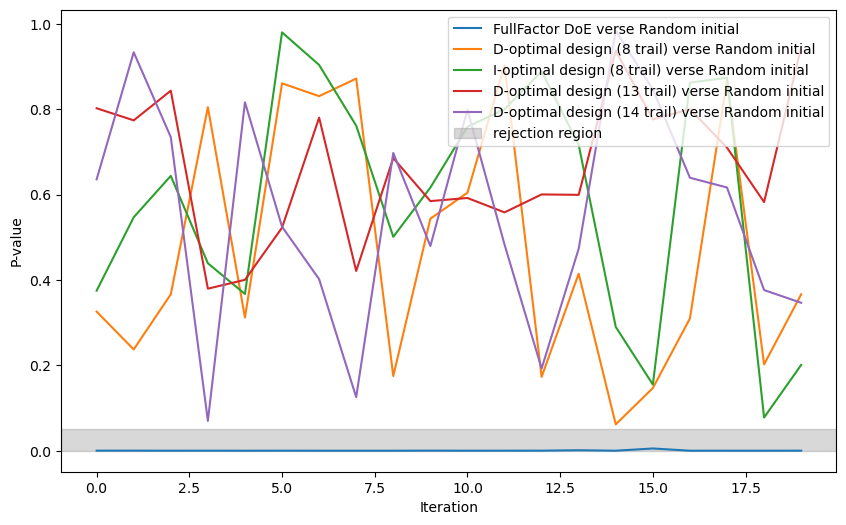

In [88]:
plt.figure(figsize=(10, 6))
plt.plot((range(20)), p_value_curve_1,label='FullFactor DoE verse Random initial')
plt.plot((range(20)), p_value_curve_2,label='D-optimal design (8 trail) verse Random initial')
plt.plot((range(20)), p_value_curve_i_1,label='I-optimal design (8 trail) verse Random initial')
plt.plot((range(20)), p_value_curve_3,label='D-optimal design (13 trail) verse Random initial')
plt.plot((range(20)), p_value_curve_4,label='D-optimal design (14 trail) verse Random initial')
plt.xlabel('Iteration')
plt.ylabel('P-value')
plt.axhspan(0, 0.05, color='gray', alpha=0.3, label='rejection region')
plt.legend(loc='upper right')
plt.show()

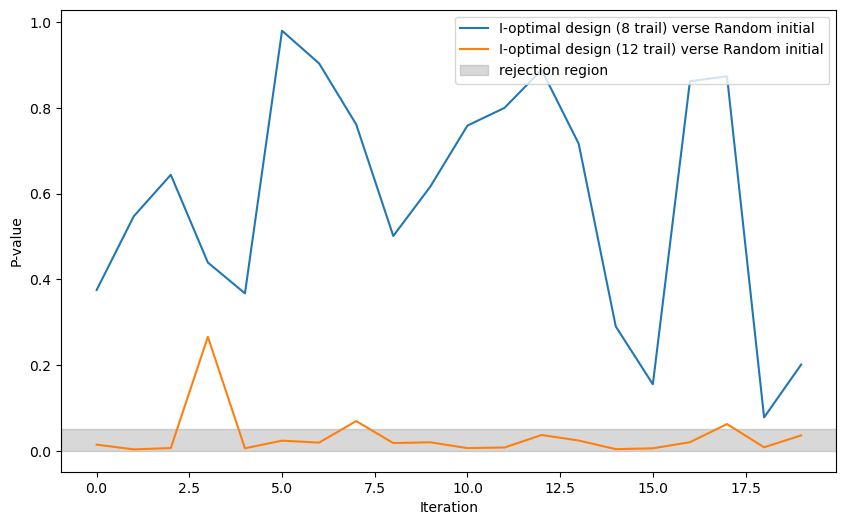

In [107]:
plt.figure(figsize=(10, 6))
plt.plot((range(20)), p_value_curve_i_1,label='I-optimal design (8 trail) verse Random initial')
plt.plot((range(20)), p_value_curve_i_2,label='I-optimal design (12 trail) verse Random initial')
plt.xlabel('Iteration')
plt.ylabel('P-value')
plt.axhspan(0, 0.05, color='gray', alpha=0.3, label='rejection region')
plt.legend(loc='upper right')
plt.show()